# Парсинг и анализ объявлений на сайте "Авито", г. Клинцы

В интернете полно статей о бизнесе в провинции, но их содержание показалось мне довольно размытым. Поэтому я решил провести собственное исследование -- выкачал все доступные объявления с "Авито" по городу, который меня заинтересовал, обработал данные и получил живой срез реальной деловой активности. Так как город довольно типичный для РФ (Центральная Россия, 80 тыс. жителей) эта информация может пригодиться не только мне, но и всем, кто интересуется подобными вопросами.

In [1]:
# Загрузка библиотек
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
import wordcloud
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

## Парсинг

In [3]:
# Сбор ссылок
page = requests.get('https://www.avito.ru/klintsy').text
page = BeautifulSoup(page, 'lxml')
page = page.find('div', class_='catalog-counts__row clearfix').find_all('a')
page_cat = []
for i in page:
    page_cat.append(re.sub('.*href=\"|\" title.*', '', str(i)))
URL = []
for i in page_cat:
    url = 'https://www.avito.ru' + i
    page = requests.get(url).text
    page = BeautifulSoup(page, 'lxml')
    try:
        n = int(re.sub('.*\?p=|\&amp.*', '', str(page.find_all('a', class_='pagination-page')[-1])))
    except:
        URL.append('https://www.avito.ru' + i[0:-3] + 'p=' + '1')      
    else:
        for j in range(1, n+1):
            url = 'https://www.avito.ru' + i[0:-3] + 'p=' + str(j)
            URL.append(url)

In [7]:
# Подделка заголовка
session = requests.Session()
headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit 537.36 (KHTML, like Gecko) Chrome",
           "Accept":"text/html,application/xhtml+xml,application/xml; q=0.9,image/webp,*/*;q=0.8"}

In [37]:
# Парсинг
for j in URL:
    time.sleep(3)
    # Загрузка сраницы
    page = session.get(j, headers=headers)
    page = BeautifulSoup(page.text, 'lxml')
    
    # Парсинг товаров
    titles = []
    for i in page.find_all('a', class_='item-description-title-link'):
        titles.append(re.sub('.*в Клинцах\">\n |\n </a>', '', str(i)))
    # Парсинг цен
    prices = []
    for i in page.find_all('div', class_='about'):
        prices.append(re.sub(' ', '',  re.findall('[\d ]+', re.sub('<div class="about">\n  |        </div>', '', str(i)))[0]))
    # Парсинг категории
    category = []
    for i in page.find_all('div', class_='data'):
        category.append(re.findall('^[\w, ]+', re.sub('^.*\n<p>|    .*', '', str(i)))[0])
    # Парсинг даты публикации
    dates = []
    for i in page.find_all('div', class_='date'):
        dates.append(re.sub('.*\n   |  </div>', '', str(i)))
    
    # Создание датафрейма
    df = pd.DataFrame({'titles': titles, 
                       'prices': prices, 
                       'category': category, 
                       'dates': dates})
    
    # Запись в файл
    df.to_csv('../data/avito_klintsy.csv', index=False, encoding='utf-8', mode='a')

## Очистка данных

In [22]:
# Загрузка данных
df = pd.read_csv('../data/avito_klintsy.csv')

In [23]:
# Удаление остаточной html-разметки
df.titles = df.titles.str.replace('^<a class="item-description-title-link" href="/klintsy/.*\r\n |$', '')
df = df[df.titles != 'titles']

# Замена NaN на 0
df.prices = df.prices.fillna(0)

# Перевод цены в числовой формат
df.prices = df.prices.astype('int')

# Трансформация заголовков в строчные буквы
df.titles = df.titles.str.lower()

In [24]:
# Сохранение данных
df.to_csv('../data/clearn_avito_klintsy.csv', index = False, encoding='utf-8')

## Объявления по категориям

Всего скачено около 12 тыс. объявлений в 48 категориях. Топ-10 наиболее популярных категорий охватывает 71% всех объявлений. Три наиболее популярных: Одежда, обувь, аксессуары -- 15%; Запчасти и аксессуары -- 14%; Детская одежда и обувь -- 13%.

In [2]:
# Загрузка данных
df = pd.read_csv('../data/clearn_avito_klintsy.csv')

In [26]:
# Данные после очистки
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11651 entries, 0 to 11650
Data columns (total 4 columns):
category    11651 non-null object
dates       11651 non-null object
prices      11651 non-null int64
titles      11651 non-null object
dtypes: int64(1), object(3)
memory usage: 364.2+ KB


,category,dates,prices,titles
0,Детская одежда и обувь,Сегодня 11:04,0,детская одежда
1,"Одежда, обувь, аксессуары",Вчера 20:38,2000,пуховик
2,"Одежда, обувь, аксессуары",Вчера 12:39,600,женская одежда
3,Детская одежда и обувь,Сегодня 11:50,700,платье
4,Детская одежда и обувь,Сегодня 11:45,1500,платье


In [4]:
# Объявление по категориям, %
pd.DataFrame(df.category.value_counts()/sum(df.category.value_counts())*100)

,category
"Одежда, обувь, аксессуары",14.900009
Запчасти и аксессуары,14.067462
Детская одежда и обувь,13.312162
Товары для детей и игрушки,6.145395
Автомобили,5.493091
Ремонт и строительство,3.965325
Предложение услуг,3.870912
Мебель и интерьер,3.364518
Телефоны,3.347352
Красота и здоровье,2.832375


In [18]:
# Топ 10 категорий
cat_top10 = pd.DataFrame(df.category.value_counts()/sum(df.category.value_counts())*100)[0:10]
cat_top10

,category
"Одежда, обувь, аксессуары",14.900009
Запчасти и аксессуары,14.067462
Детская одежда и обувь,13.312162
Товары для детей и игрушки,6.145395
Автомобили,5.493091
Ремонт и строительство,3.965325
Предложение услуг,3.870912
Мебель и интерьер,3.364518
Телефоны,3.347352
Красота и здоровье,2.832375


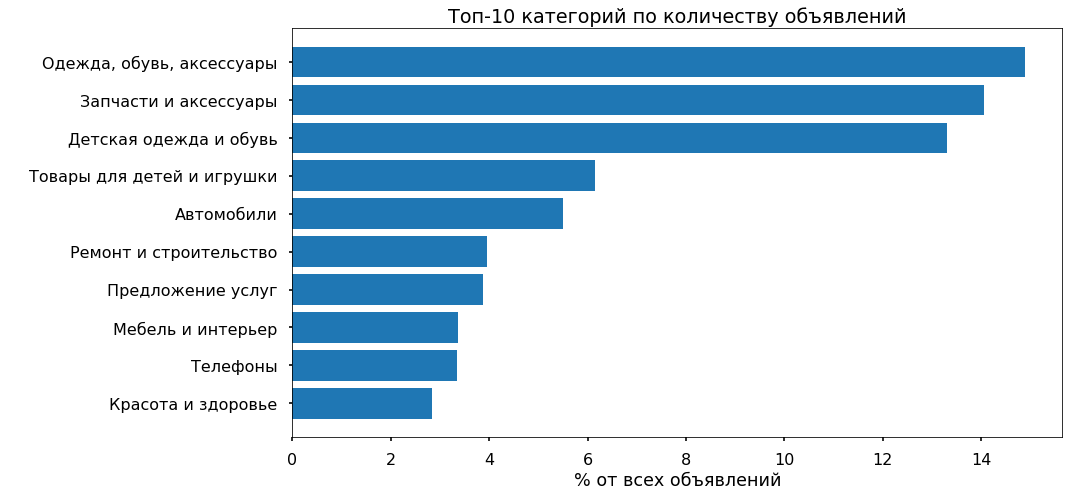

In [32]:
# График "Топ10 категорий"
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(cat_top10.index))[::-1], cat_top10.category)
ax.set_yticks(np.arange(len(cat_top10.index))[::-1])
ax.set_yticklabels(cat_top10.index)
plt.title('Топ-10 категорий по количеству объявлений')
plt.ylabel(' ')
plt.xlabel('% от всех объявлений')
plt.tight_layout()
plt.show()
fig.savefig('../images/Топ10 категорий.png')

## Теги для объявлений из Топ-10 категорий

Чтобы понять, что именно предлагается в этих разделах, я распарсил тексты и представил их в виде облаков тегов -- чем слово крупнее, тем чаще оно встречается.

In [34]:
# Создание цветовой карты
colors = ["#000000", "#111111", "#222222"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

### 1. Одежда, обувь, аксессуары

"Одежда, обувь, аксессуары" -- самая популярная и представлена в основном товарами для женщин: платья, куртки, туфли, пальто, сапоги, шубы -- как б/у, так и новые -- 400-2000 р. в среднем (здесь и далее я использую межквартильный размах цен).

Вообще именно женская бизнес-активность на городских интернет-ресурсах является основной. Преимущественно женские категории (Одежда, обувь, аксессуары; Детская одежда и обувь; Товары для детей и игрушки; Красота и здоровье; Посуда и товары для кухни; Часы и украшения) охватывают более 40% всех объявлений. Мужские (Запчасти и аксессуары; Автомобили; Ремонт и строительство) -- около 24%. В остальных категориях мужчины и женщины представлены примерно одинаково.

Пока парни думают, каким именно бизнесом заняться, девушки торгуют товарами с Алиэкспресса, делают маникюр, наращивают волосы, открывают парикмахерские и кафе, пекут на заказ торты... Многие в провинции не обращают должного внимания на товары и услуги для женщин, считая это чем-то несерьёзным, как мне думается, зря.

In [5]:
# От 400 до 2 тыс. р.
df.prices[(df.category == 'Одежда, обувь, аксессуары') & (df.prices !=0)].describe()

count     1689.000000
mean      2162.455299
std       4638.412777
min          1.000000
25%        400.000000
50%        800.000000
75%       2000.000000
max      65000.000000
Name: prices, dtype: float64

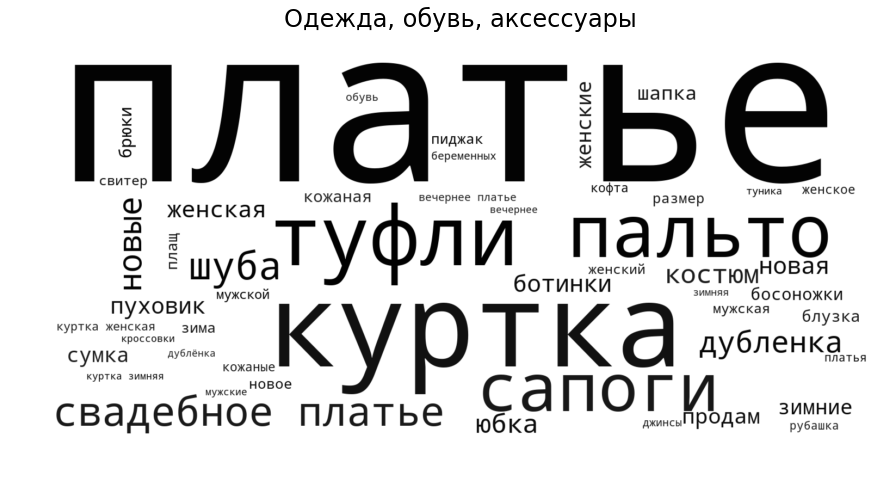

In [47]:
# Облако тэгов
words = ' '.join(df.titles[df.category == 'Одежда, обувь, аксессуары'])
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=400,
                            width=1500,
                            height=700,
                            max_words=50,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из']
                            ).generate(words)
fig = plt.figure(figsize=(15,7))
plt.title('Одежда, обувь, аксессуары\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.show()
fig.savefig('../images/Одежда обувь аксессуары - теги.png')

### 2. Запчасти и аксессуары

Под запчастями и аксессуарами подразумевают диски, шины, колёса, бамперы, двери, магнитолы в основном для отечественных автомобилей, в меньшей мере для ауди, мерседеса, фольксвагена, мазды -- по цене от 1 тыс. до 5 тыс. рублей.

In [6]:
# От 1 тыс. до 5 тыс. р.
df.prices[(df.category == 'Запчасти и аксессуары') & (df.prices !=0)].describe()

count      1479.000000
mean       6142.293442
std       16237.689641
min           1.000000
25%         999.000000
50%        2000.000000
75%        5000.000000
max      209550.000000
Name: prices, dtype: float64

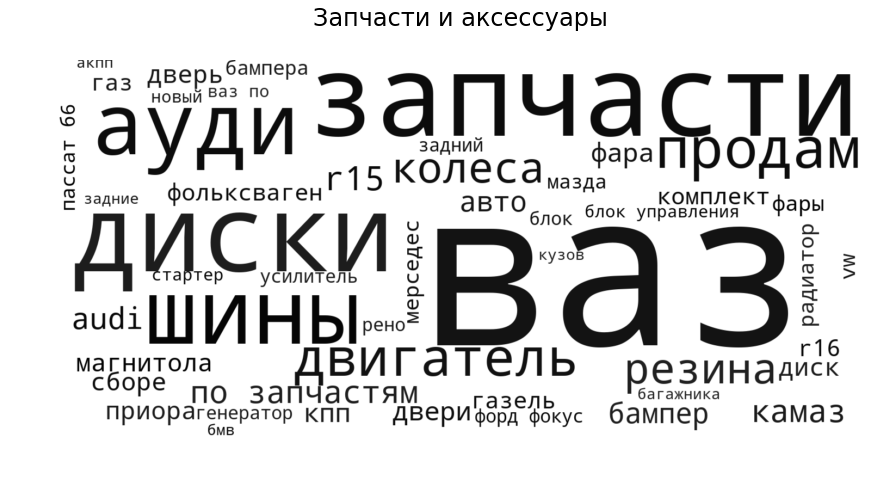

In [49]:
# Облако тэгов
words = ' '.join(df.titles[df.category == 'Запчасти и аксессуары'])
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=400,
                            width=1500,
                            height=700,
                            max_words=50,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из']
                            ).generate(words)
fig = plt.figure(figsize=(15,7))
plt.title('Запчасти и аксессуары\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.show()
fig.savefig('../images/Запчасти и аксессуары - теги.png')

### 3. Детская одежда и обувь

Основные товары -- платья, комбинзоны, куртки для девочек. Костюмы для мальчиков продаются в меньшей степени, уж не знаю почему. Цены -- от 200 до 700 рублей, высока доля секондхенда.

In [22]:
# От 200 до 700 р.
df.prices[(df.category == 'Детская одежда и обувь') & (df.prices !=0)].describe()

count     1502.000000
mean       695.848202
std       1355.554365
min          1.000000
25%        200.000000
50%        400.000000
75%        700.000000
max      20000.000000
Name: prices, dtype: float64

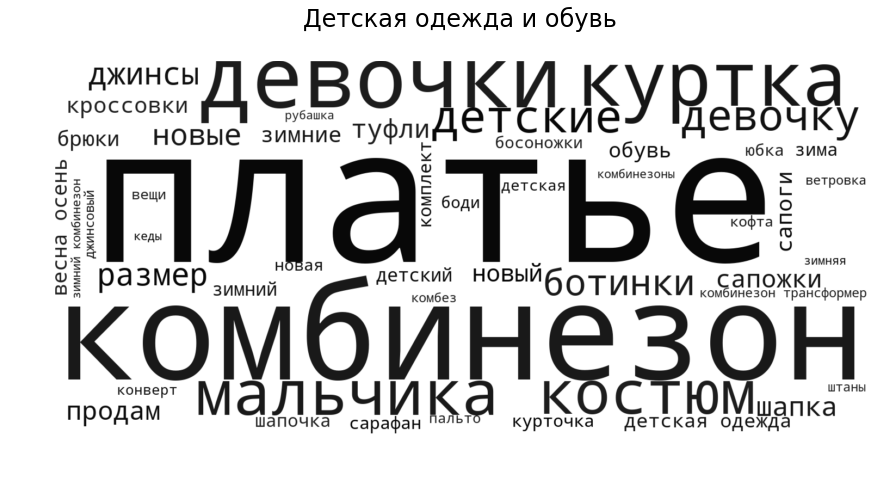

In [55]:
# Облако тэгов
words = ' '.join(df.titles[df.category == 'Детская одежда и обувь'])
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=350,
                            width=1500,
                            height=700,
                            max_words=50,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из', 'мес', 'года', 'лет']
                            ).generate(words)
fig = plt.figure(figsize=(15,7))
plt.title('Детская одежда и обувь\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.show()
fig.savefig('../images/Детская одежда и обувь - теги.png')

### 4. Товары для детей и игрушки

Под товарами для детей подразумевают в основном коляски и детские кроватки б/у -- от 400 до 3 тыс. рублей -- место занимают, уже не нужны, а выбросить жалко.

In [8]:
# От 400 до 3 тыс. р.
df.prices[(df.category == 'Товары для детей и игрушки') & (df.prices !=0)].describe()

count       696.000000
mean       2730.831897
std       10264.255369
min           1.000000
25%         350.000000
50%        1000.000000
75%        2500.000000
max      250700.000000
Name: prices, dtype: float64

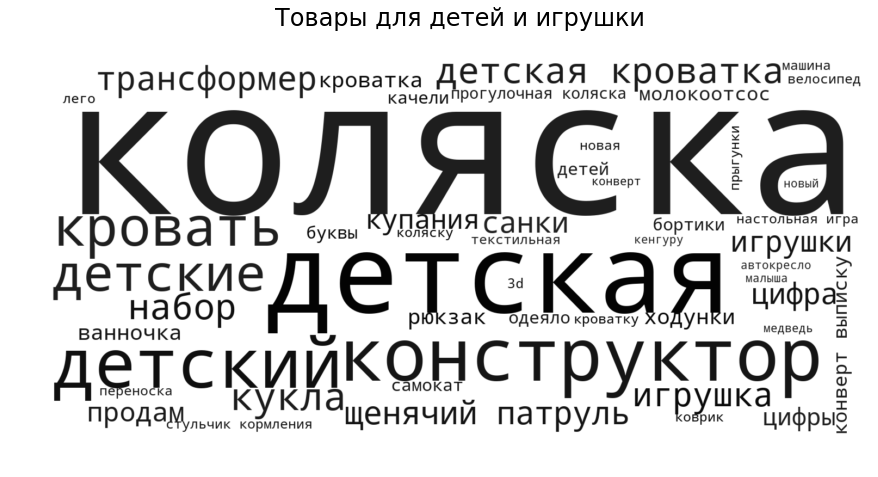

In [60]:
# Облако тэгов
words = ' '.join(df.titles[df.category == 'Товары для детей и игрушки'])
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=350,
                            width=1500,
                            height=700,
                            max_words=50,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из']
                            ).generate(words)
fig = plt.figure(figsize=(15,7))
plt.title('Товары для детей и игрушки\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.show()
fig.savefig('../images/Товары для детей и игрушки - теги.png')

### 5. Автомобили

Наиболее популярные марки автомобилей: ВАЗ Samara, Lada Priora, Mercedes Benz, Volkswagen Passat, Mazda, Hyundai, Audi, Toyota -- 130-450 тыс. р.

In [3]:
# От 130 тыс. до 450 тыс. р.
df.prices[(df.category == 'Автомобили') & (df.prices !=0)].describe()

count    6.400000e+02
mean     3.337256e+05
std      3.058390e+05
min      9.000000e+03
25%      1.250000e+05
50%      2.500000e+05
75%      4.500000e+05
max      2.099000e+06
Name: prices, dtype: float64

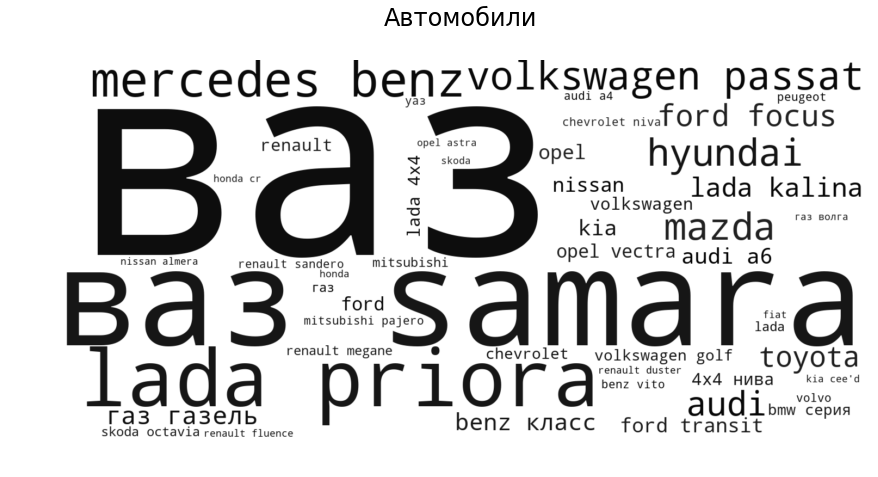

In [63]:
# Облако тэгов
words = ' '.join(df.titles[df.category == 'Автомобили'])
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=500,
                            width=1500,
                            height=700,
                            max_words=50,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из']
                            ).generate(words)
fig = plt.figure(figsize=(15,7))
plt.title('Автомобили\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.show()
fig.savefig('../images/Автомобили - теги.png')

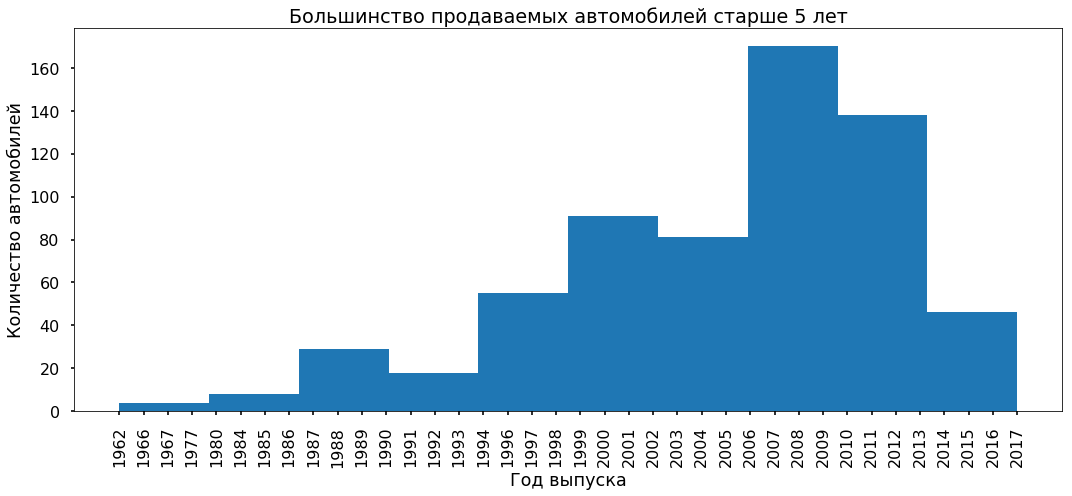

In [67]:
# График "Год выпуска автомобилей"
cars_year = []
for i in df[df.titles.str.contains('\d+')][df.category == 'Автомобили'].titles.str.findall('\d+'):
    cars_year.append(i[-1])

fig = plt.figure(figsize=(15,7))
plt.xticks(rotation=90)
plt.hist(cars_year)
plt.title('Большинство продаваемых автомобилей старше 5 лет')
plt.ylabel('Количество автомобилей')
plt.xlabel('Год выпуска')
plt.tight_layout()
plt.show()
fig.savefig('../images/Год выпуска автомобилей.png')

### 6. Ремонт и строительство

Установка дверей, входных и межкомнатных, внутренняя отделка, установка газовых котлов и колонок, продажа мотоблоков и насосов, дров, кирпича, песка, профлиста, плитки -- 10 тыс. в среднем.

In [10]:
# От 400 до 5 тыс. р.
df.prices[(df.category == 'Ремонт и строительство') & (df.prices !=0)].describe()

count        408.000000
mean        8328.450980
std        51898.383362
min            1.000000
25%          434.250000
50%         1500.000000
75%         5000.000000
max      1000000.000000
Name: prices, dtype: float64

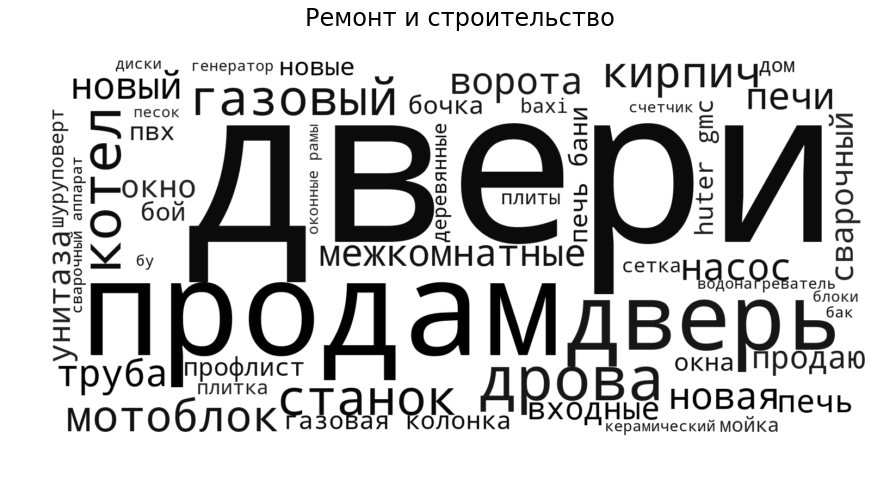

In [70]:
# Облако тэгов
words = ' '.join(df.titles[df.category == 'Ремонт и строительство'])
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=400,
                            width=1500,
                            height=700,
                            max_words=50,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из', 'по', 'под']
                            ).generate(words)
fig = plt.figure(figsize=(15,7))
plt.title('Ремонт и строительство\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.show()
fig.savefig('../images/Ремонт и строительство - теги.png')

### 7. Предложение услуг

Ремонт (натяжные потолки, отделочные работы) -- 400 р. в среднем.  Грузоперевозка -- 200 р. Маникюр, наращивание волос -- 400 р.

In [23]:
# Средняя цена -- 400 р.
df.prices[(df.category == 'Предложение услуг') & (df.prices !=0) & (df.titles.str.contains('ремонт'))].describe()

count      32.000000
mean      394.687500
std       571.774963
min         1.000000
25%       100.000000
50%       250.000000
75%       337.500000
max      3000.000000
Name: prices, dtype: float64

In [6]:
# 200 р.
df.prices[(df.category == 'Предложение услуг') & (df.prices !=0) & (df.titles.str.contains('грузоперевозки'))].mean()

164.65

In [7]:
# 400 р.
df.prices[(df.category == 'Предложение услуг') & (df.prices !=0) & (df.titles.str.contains('маникюр'))].mean()

438.8888888888889

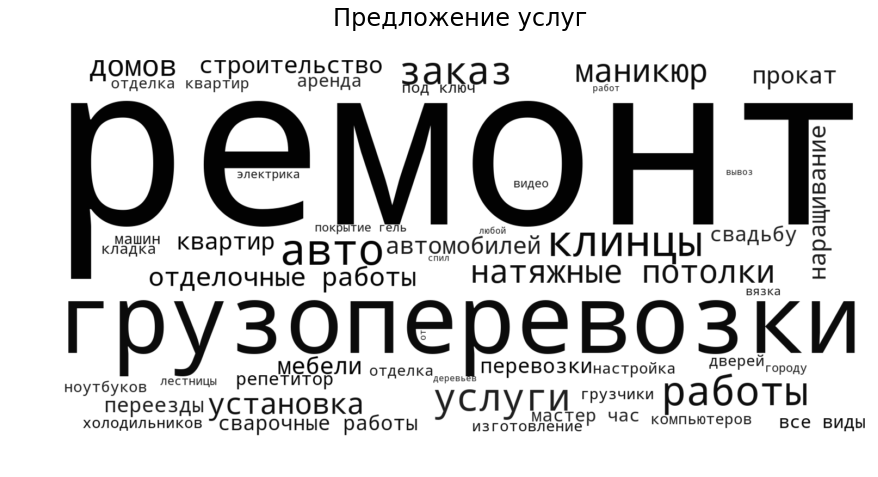

In [75]:
# Облако тэгов
words = ' '.join(df.titles[df.category == 'Предложение услуг'])
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=500,
                            width=1500,
                            height=700,
                            max_words=50,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из', 'до', 'по', 'ваш']
                            ).generate(words)
fig = plt.figure(figsize=(15,7))
plt.title('Предложение услуг\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.show()
fig.savefig('../images/Предложение услуг - теги.png')

# 8. Мебель и интерьер

Самая популярная мебель -- диван, шкаф, стол, кровать, кресло -- от 5 тыс. до 14 тыс. в среднем.

In [24]:
# От 700 до 5 тыс. р.
df.prices[(df.category == 'Мебель и интерьер') & (df.prices !=0) & (df.titles.str.contains('диван')|df.titles.str.contains('шкаф'))].describe()

count       67.000000
mean      8299.835821
std       7082.129344
min        100.000000
25%       3250.000000
50%       6500.000000
75%       9250.000000
max      28000.000000
Name: prices, dtype: float64

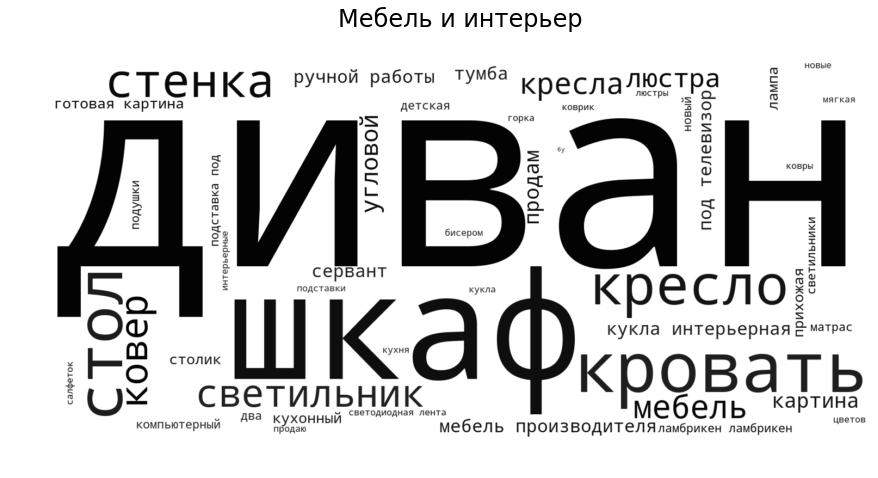

In [79]:
# Облако тэгов
words = ' '.join(df.titles[df.category == 'Мебель и интерьер'])
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=500,
                            width=1500,
                            height=700,
                            max_words=50,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из', 'от']
                            ).generate(words)
fig = plt.figure(figsize=(15,7))
plt.title('Мебель и интерьер\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.show()
fig.savefig('../images/Мебель и интерьер - теги.png')

### 9. Телефоны

Б/у Айфоны 4s, 5s, 6s побеждают с большим отрывом -- от 6 до 20 тыс. р.

In [13]:
# Телефоны от 700 до 8 тыс. р.
df.prices[(df.category == 'Телефоны') & (df.prices !=0)].describe()

count      382.000000
mean      5592.505236
std       7043.002325
min          1.000000
25%        650.000000
50%       3500.000000
75%       8000.000000
max      47000.000000
Name: prices, dtype: float64

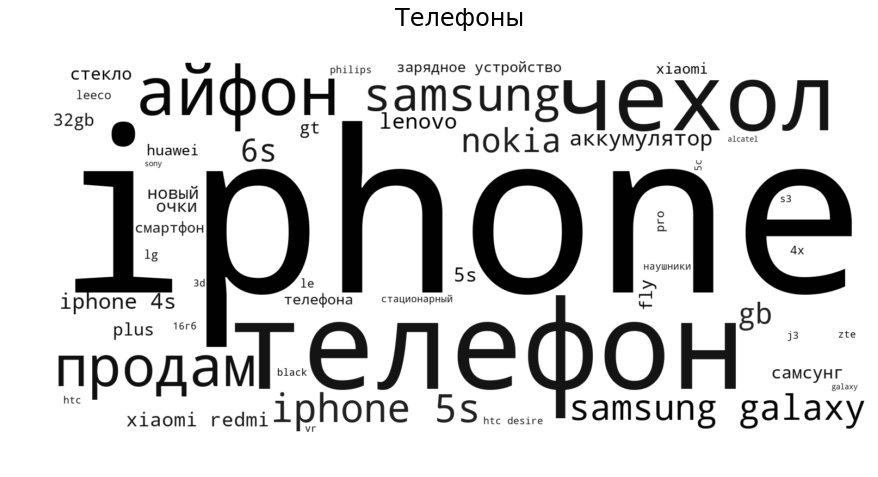

In [83]:
# Облако тэгов
words = ' '.join(df.titles[df.category == 'Телефоны'])
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=700,
                            width=1500,
                            height=700,
                            max_words=50,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из']
                            ).generate(words)
fig = plt.figure(figsize=(15,7))
plt.title('Телефоны\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.show()
fig.savefig('../images/Телефоны - теги.png')

In [86]:
# Айфоны от 6 тыс. до 20 тыс.
df[df.titles.str.contains('iphone')].prices[df.prices > 3000].describe()

count       65.000000
mean     12172.000000
std       8737.822991
min       3500.000000
25%       5500.000000
50%       9000.000000
75%      17000.000000
max      46000.000000
Name: prices, dtype: float64

### 10. Красота и здоровье

Красота и здоровье -- чисто женская рубрика. Наиболее популярный товар -- туалетная вода -- от 250 до 1 тыс. р.

In [12]:
# Туалетная вода от 250 до 1 тыс. р.
df.prices[(df.category == 'Красота и здоровье') & (df.prices !=0) & (df.titles.str.contains('туалетная вода'))].describe()

count      25.000000
mean      621.880000
std       407.704685
min       189.000000
25%       250.000000
50%       500.000000
75%       990.000000
max      1500.000000
Name: prices, dtype: float64

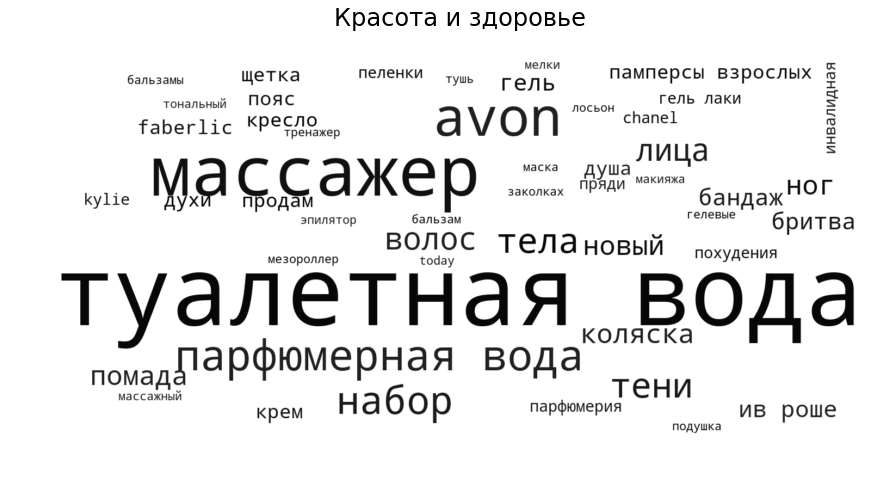

In [92]:
# Облако тэгов
words = ' '.join(df.titles[df.category == 'Красота и здоровье'])
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=800,
                            width=1500,
                            height=700,
                            max_words=50,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из', 'от', 'мл']
                            ).generate(words)
fig = plt.figure(figsize=(15,7))
plt.title('Красота и здоровье\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.show()
fig.savefig('../images/Красота и здоровье - теги.png')

### Резюме и Вакансии

Резюме и вакансии не входят в Топ, но являются тематическими категориями. Соискатели ищут работу водителя, менеджера, продавца консультанта -- за 15 тыс. рублей. Работодатели готовы предложить вакансии продавца, кассира, торгового представителя -- за 20 тыс. рублей. Подозреваю, немного лукавят. По оперативным данным, средняя зарплата в городе -- 12-15 тыс.

In [101]:
# Резюме -- 15 тыс. р. в среднем
df.prices[(df.category == 'Резюме') & (df.prices !=0)].median()

15000.0

In [102]:
# Резюме -- 20 тыс. р. в среднем
df.prices[(df.category == 'Вакансии') & (df.prices !=0)].median()

20000.0

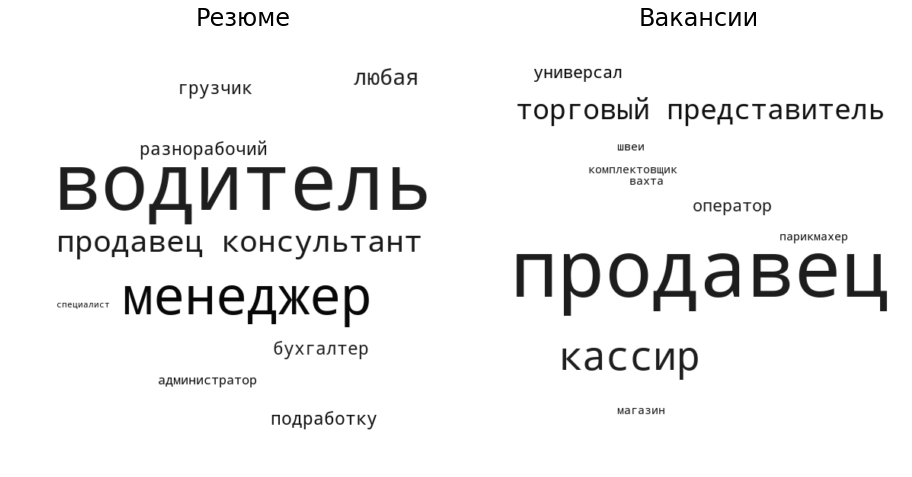

In [154]:
# Облако тэгов
words = ' '.join(df.titles[df.category == 'Резюме'])
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=280,
                            width=500,
                            height=500,
                            max_words=10,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из', 'по', 'за', 'не', 'ищу работу', 'ищу', 'работу', 'варианты',
                                        'подработка']
                            ).generate(words)

words1 = ' '.join(df.titles[df.category == 'Вакансии'])
cloud1 = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=280,
                            width=500,
                            height=500,
                            max_words=10,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из', 'по', 'за', 'не', 'Клинцы', 'требуются', 'магазина']
                            ).generate(words1)

fig = plt.figure(figsize=(15,7))
plt.subplot(121)
plt.title('Резюме\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.subplot(122)
plt.title('Вакансии\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud1, interpolation="bilinear")


plt.show()
fig.savefig('../images/Резюме и Вакансии - теги.png')

### Оборудование для бизнеса и Готовый бизнес

Наиболее популярные теги: кафе, фотосалоны, парикмахерские, магазины, автосервисы, мясокомбинаты, пилорамы и соответствующее оборудование. Готовый бизнес обойдётся в среднем от 100 тыс до 1 млн.

In [18]:
# Оборудование для бизнеса -- 6-100 тыс.
df.prices[(df.category == 'Оборудование для бизнеса') & (df.prices !=0)].describe()

count        24.000000
mean     123843.333333
std      209016.720002
min          40.000000
25%        5875.000000
50%       18500.000000
75%       99925.000000
max      700000.000000
Name: prices, dtype: float64

In [21]:
# Готовый бизнес -- от 100 тыс. до 1 млн. р. в среднем
df.prices[(df.category == 'Готовый бизнес') & (df.prices !=0)].describe()

count    1.500000e+01
mean     3.418073e+06
std      1.123922e+07
min      1.000000e+02
25%      1.250000e+05
50%      3.500000e+05
75%      9.000000e+05
max      4.400000e+07
Name: prices, dtype: float64

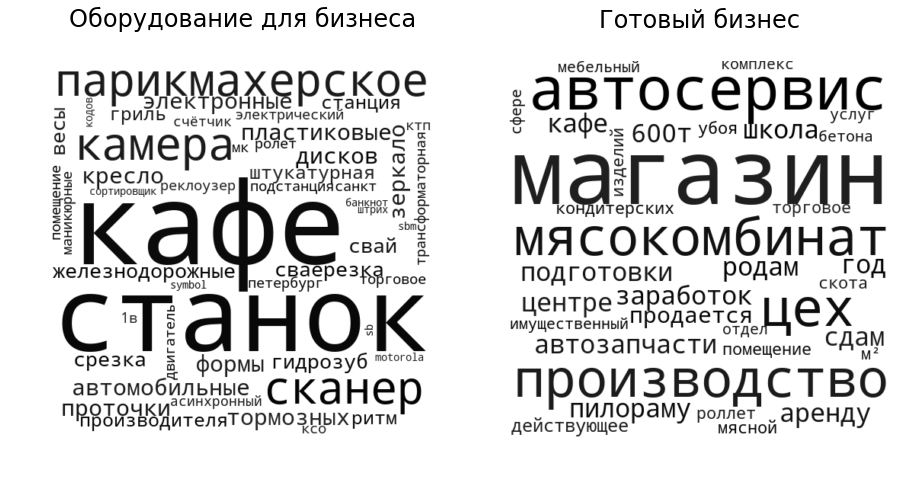

In [150]:
# Облако тэгов
words = ' '.join(df.titles[df.category == 'Оборудование для бизнеса'])
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=150,
                            width=500,
                            height=500,
                            max_words=50,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из', 'оборудование', 'продам', 'от']
                            ).generate(words)
words1 = ' '.join(df.titles[df.category == 'Готовый бизнес'])
cloud1 = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=200,
                            width=500,
                            height=500,
                            max_words=50,
                            relative_scaling=1,
                            stopwords = ['для', 'на', 'из', 'оборудование', 'продам', 'от', 'готовый', 'бизнес']
                            ).generate(words1)

fig = plt.figure(figsize=(15,7))
plt.subplot(121)
plt.title('Оборудование для бизнеса\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.subplot(122)
plt.title('Готовый бизнес\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud1, interpolation="bilinear")

plt.show()
fig.savefig('../images/Оборудование для бизнеса и Готовый бизнес - теги.png')

## Структура малого и среднего бизнеса в провинции:
1. Женский сегмент:
   1. Торговля товарами для детей (одежда и обувь, игрушки, коляски, кроватки);
   2. Торговля товарами для женщин (одежда и обувь, парфюмерия, косметика, украшения);
   3. Услуги для женщин (парикмахерские, маникюр, фотоуслуги);
2. Автомобильный сегмент:
   1. Продажа автомобильных запчастей и аксессуаров;
   2. Торговля подержанными автомобилями;
   3. Автосервис;
3. Грузо- и пассажироперевозки;
4. Услуги и товары для строительства и ремонта (внутренняя отделка, установка газового оборудования, монтаж дверей, натяжных потолков, сантехники, продажа строительных материалов);
5. Продажа и изготовление мебели;
6. Торговля и производство кулинарной продукции (кафе, магазины кулинарии, киоски);
7. Ремонт и перепродажа бытовой электроники (телефоны, ноутбуки, компьютеры, холодильники, телевизоры).